## Sinus Diagnoising System 

### import python file

In [1]:
from SDC import *
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Load CT images

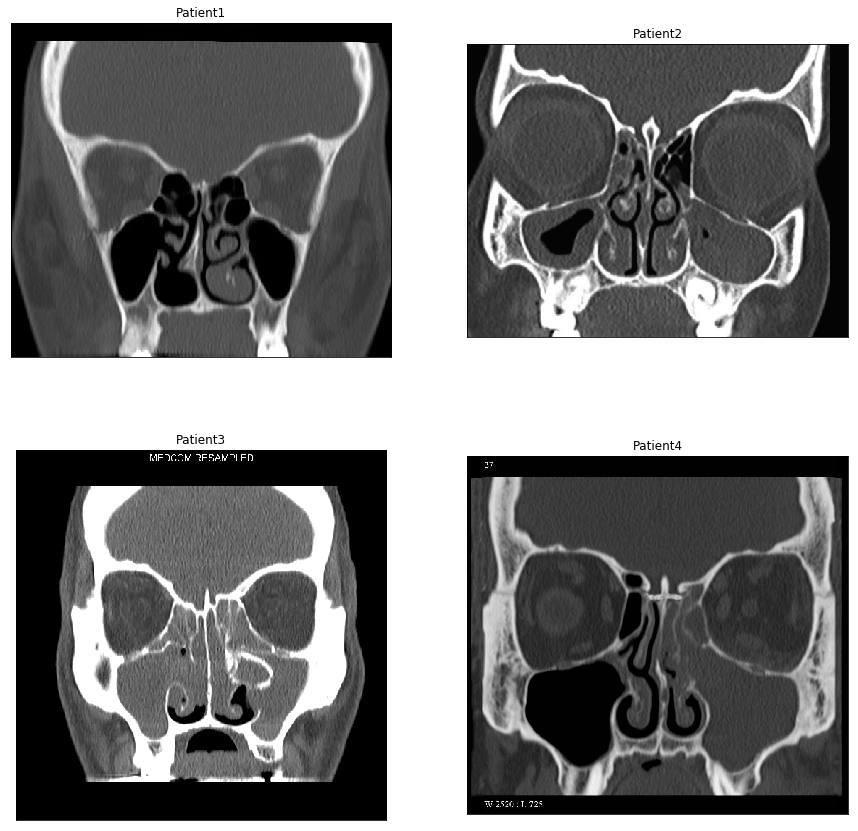

In [2]:


img1 = img = cv2.imread('CT/c7.jpg',0) 
img2 = img = cv2.imread('CT/c13.jpg',0) 
img3 = img = cv2.imread('CT/c14.jpg',0) 
img4 = img = cv2.imread('CT/c15.jpg',0) 

images = [img1, img2, img3, img4]
image_name = ["Patient1", "Patient2", "Patient3", "Patient4"]

fig = plt.figure(figsize=(15, 15))
for i in range(0, len(images)):
    plt.subplot(2, 2, i+1) ,plt.imshow(images[i],cmap = 'gray')
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Histogram for all images

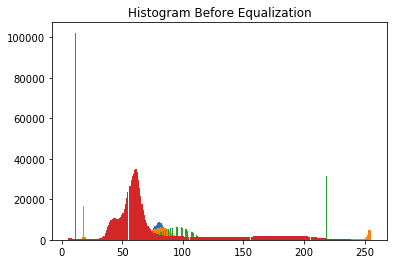

In [3]:
for i in range(0,len(images)):
    plt.hist(images[i].ravel(),256,[5,256])                                
    plt.title("Histogram Before Equalization") 
plt.show()

### Apply contrast Limited Adaptive Histogram Equalization (CLAHE) method

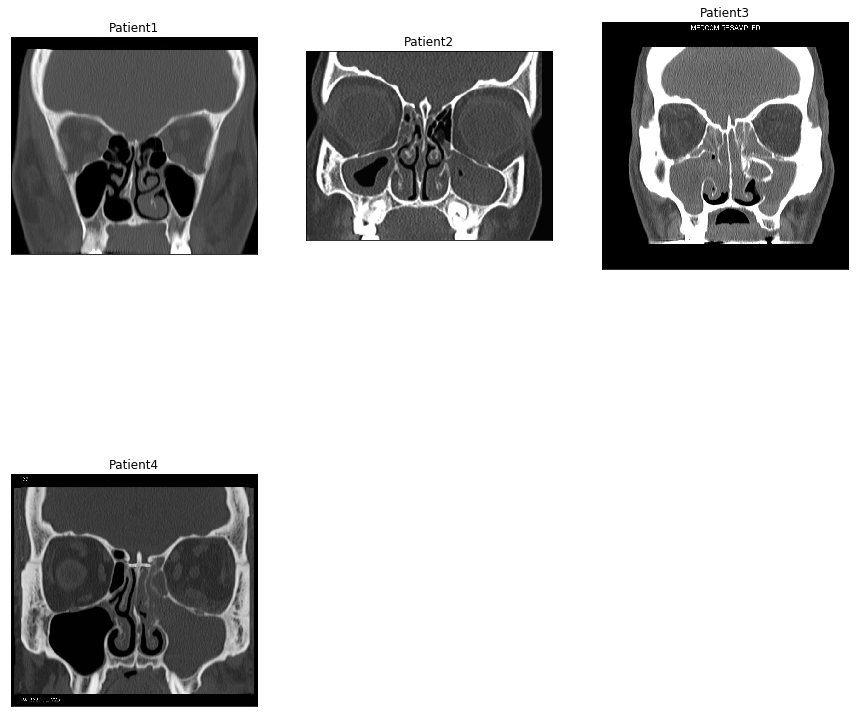

In [4]:
clahe = [0] * 4
for i in range(0,len(images)):
    clahe[i] = adaptive_equalization(images[i])
fig = plt.figure(figsize=(15,15))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(images[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Histogram after apply CLAHE method

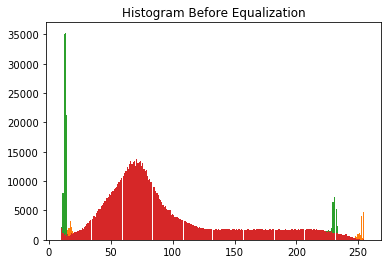

In [5]:
for i in range(0,len(clahe)):
    plt.hist(clahe[i].ravel(),256,[10,256])                                
    plt.title("Histogram Before Equalization") 
plt.show()

###  Apply Edge Detection-Canny

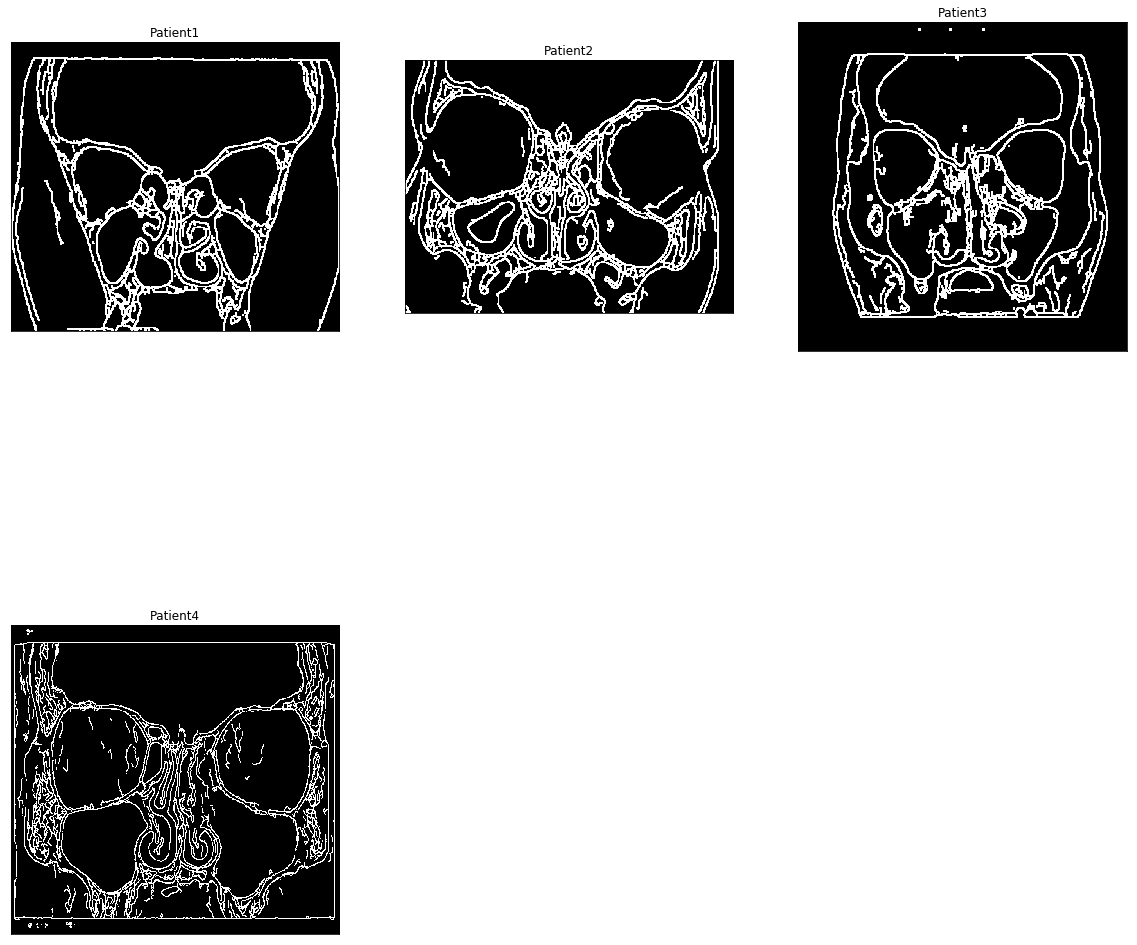

In [6]:
edges = [0] * 4
for i in range(0,len(images)):
    edges[i] = make_edges(images[i])


fig = plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(edges[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Remove backgroud from image

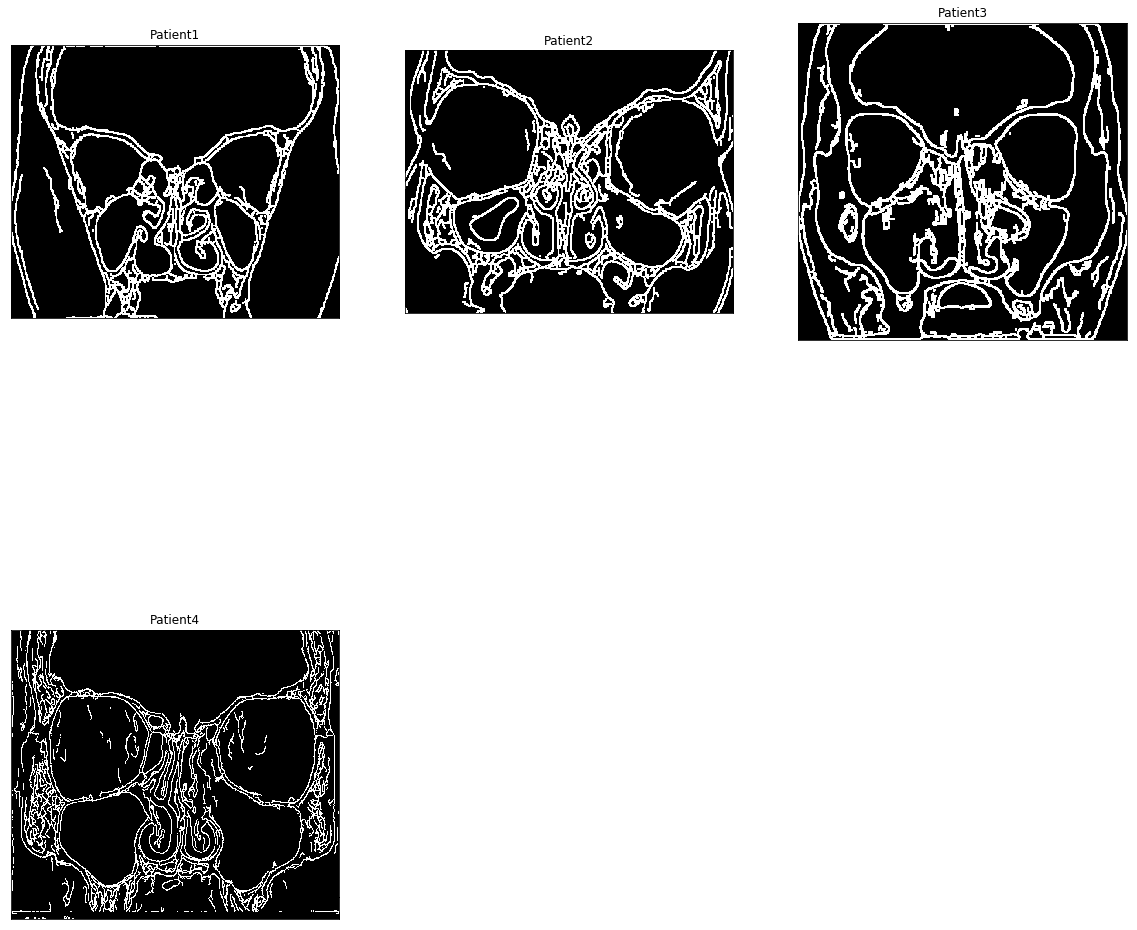

In [7]:
crop_orig = [0] * 4
crop_edges = [0] * 4
for i in range(0,len(images)):
    crop_orig[i] = crop_background(clahe[i], edges[i])
    crop_edges[i] = crop_background(edges[i], edges[i])
fig = plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(crop_edges[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Resize images  to standardize sizes

In [8]:
resize_edges = [0] * 4
resize_orig = [0] * 4
for i in range(0,len(images)):
    resize_edges[i] = resize_image(crop_edges[i], 700)
    resize_orig[i] = resize_image(crop_orig[i], 700)

### Threshold Bones Structure

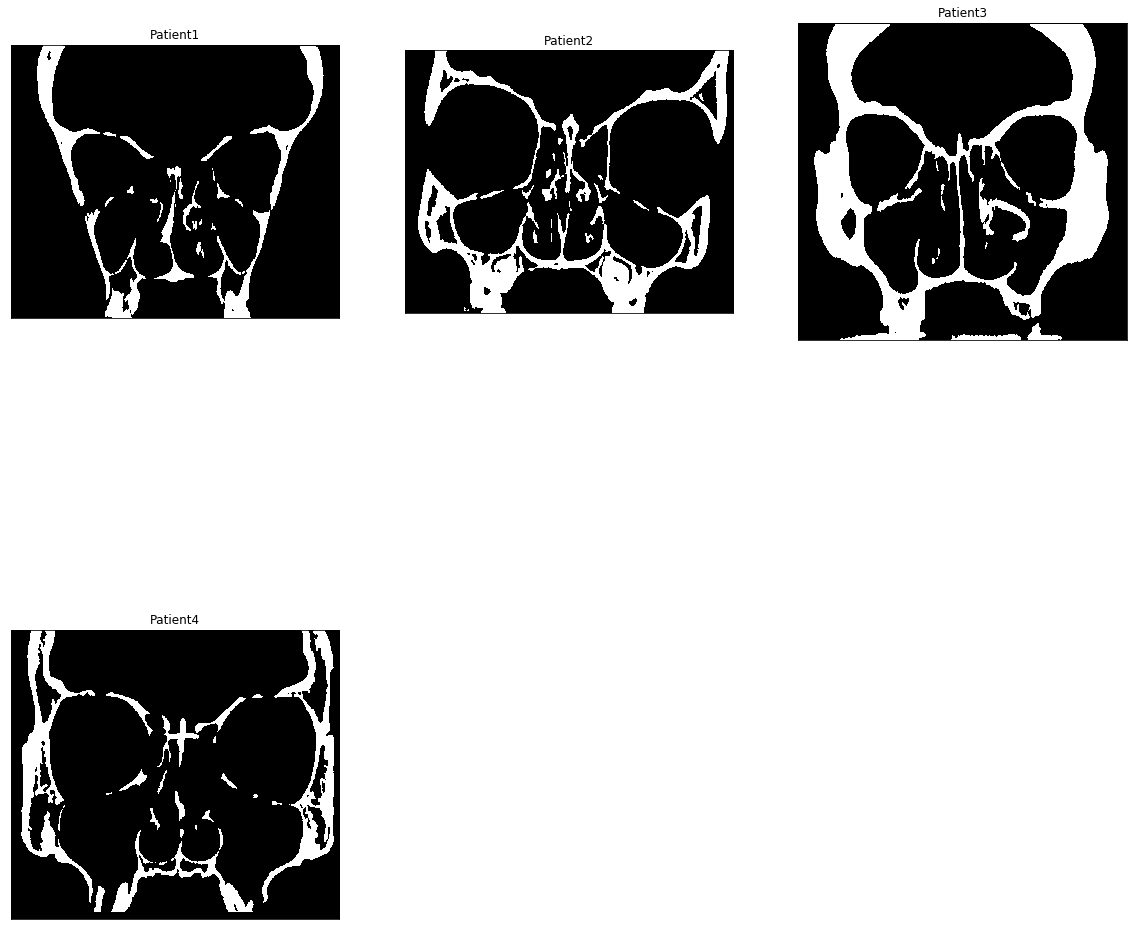

In [9]:
thresh_image = [0] * 4
for i in range(0,len(images)):
    thresh_image[i] = make_threshold(resize_orig[i])

fig = plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(thresh_image[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Remove mandible bone from skull

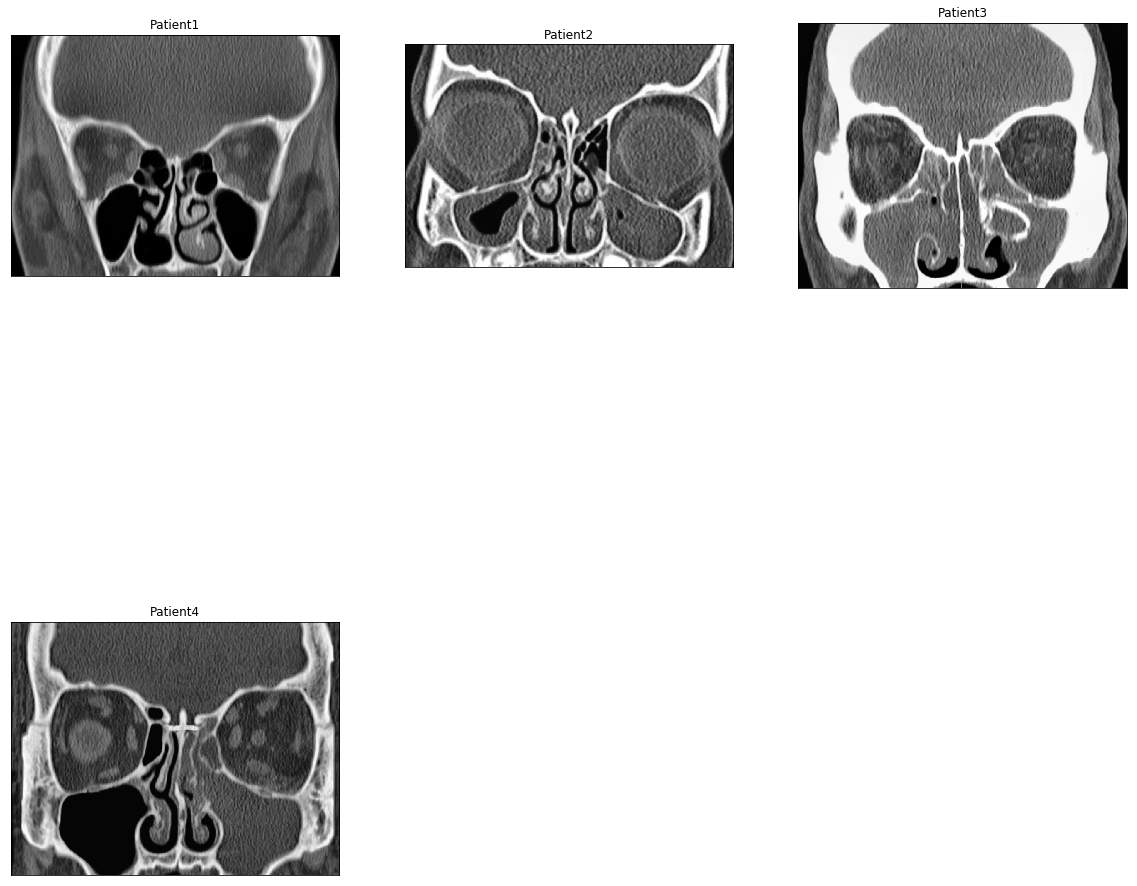

In [10]:
for i in range(0,len(images)):
    resize_edges[i] = crop_mouth(resize_edges[i], thresh_image[i])
    resize_orig[i] = crop_mouth(resize_orig[i], thresh_image[i])
    thresh_image[i] = crop_mouth(thresh_image[i], thresh_image[i])

fig = plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(resize_orig[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Merge Bone Structure with edge detection

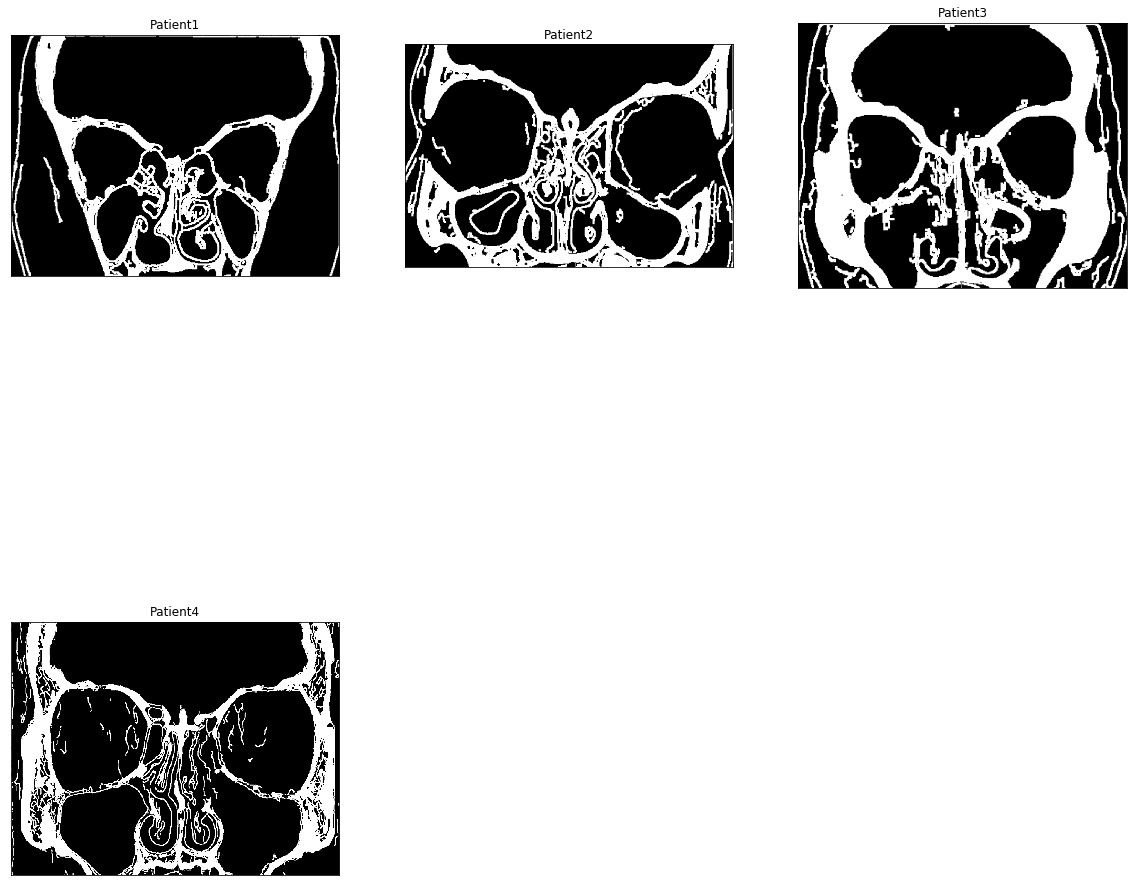

In [11]:
merge_image = [0] * 5

for i in range(0,len(images)):
    merge_image[i] = make_merge(resize_edges[i], thresh_image[i])

fig = plt.figure(figsize=(20,20))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(merge_image[i],cmap = 'gray')                                
    plt.title(image_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

### Apply active contour and detect sinuses

In [15]:
im1 = [0] * 4
im2 = [0] * 4
imgRight = [0] * 4
imgLeft = [0] * 4

for i in range(0,len(images)):
    im1[i], im2[i] = active_contour(merge_image[i], thresh_image[i])
    imgRight[i] = im1[i] ^ merge_image[i]
    imgLeft[i] = im2[i] ^ imgRight[i]
    

### Extract Region of Interest

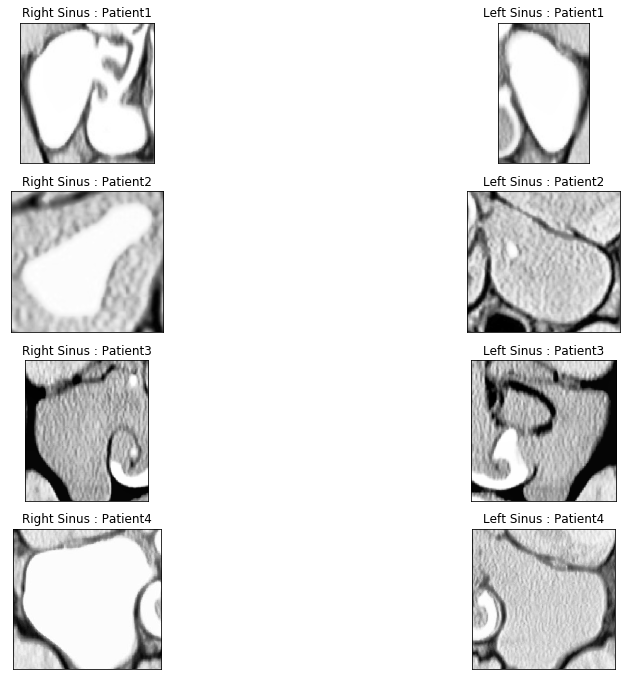

In [14]:
sinus1 = [0] * 4
sinus2 = [0] * 4

for i in range(0,len(images)):
    sinus1[i] = extract_roi(im1[i], resize_orig[i], padding=20)
    sinus2[i] = extract_roi(im2[i], resize_orig[i], padding=20)

fig = plt.figure(figsize=(15,15))
c=1

for i in range(len(images)):
    plt.subplot(5,2,c),plt.imshow(sinus1[i], cmap=ppl.cm.Greys)                                
    plt.title("Right Sinus : "+image_name[i]), plt.xticks([]), plt.yticks([])
    c+=1
    plt.subplot(5,2,c),plt.imshow(sinus2[i], cmap=ppl.cm.Greys)
    plt.title("Left Sinus : "+image_name[i]), plt.xticks([]), plt.yticks([])
    c+=1
plt.show()

### Diagnoises using Gradient Boosting algorithm

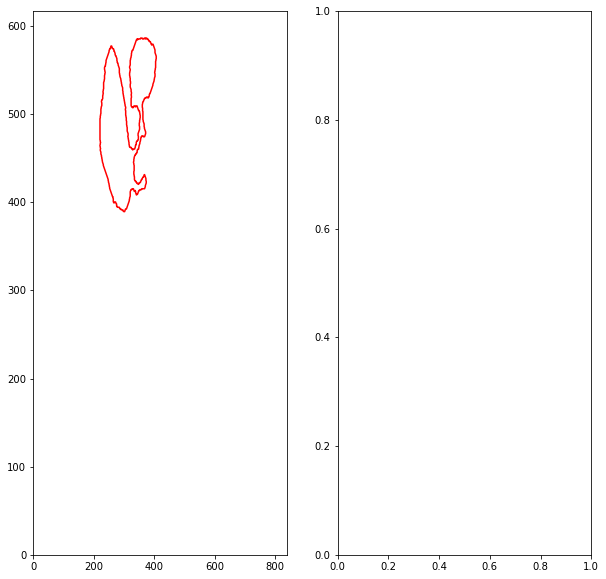

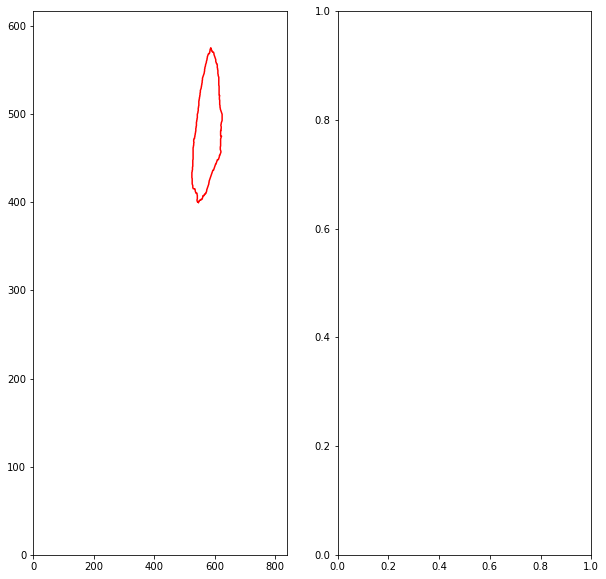

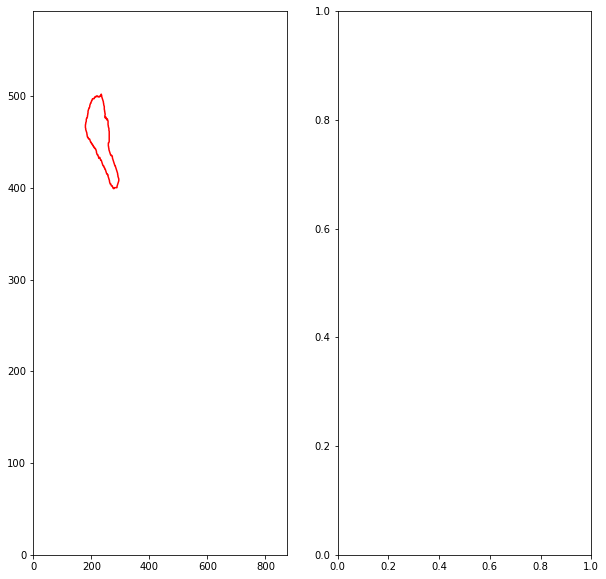

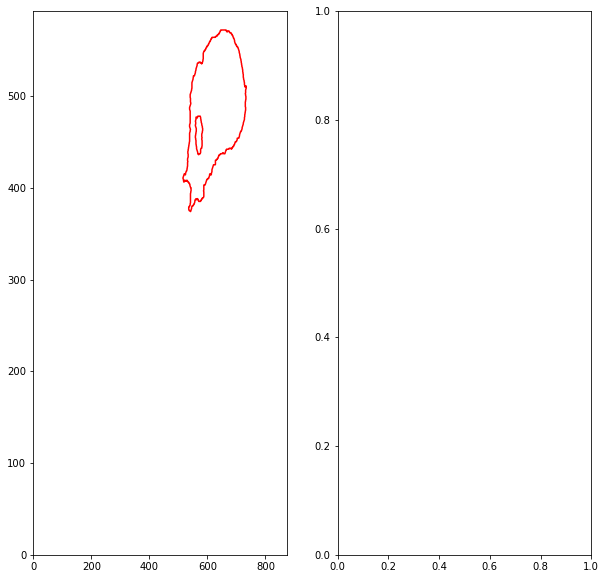

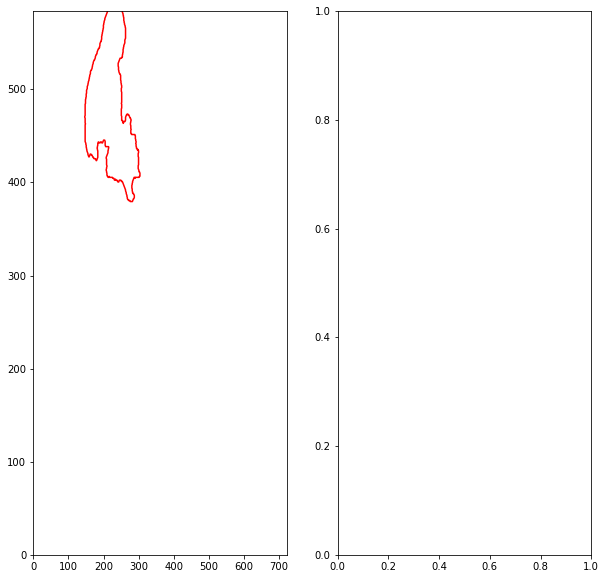

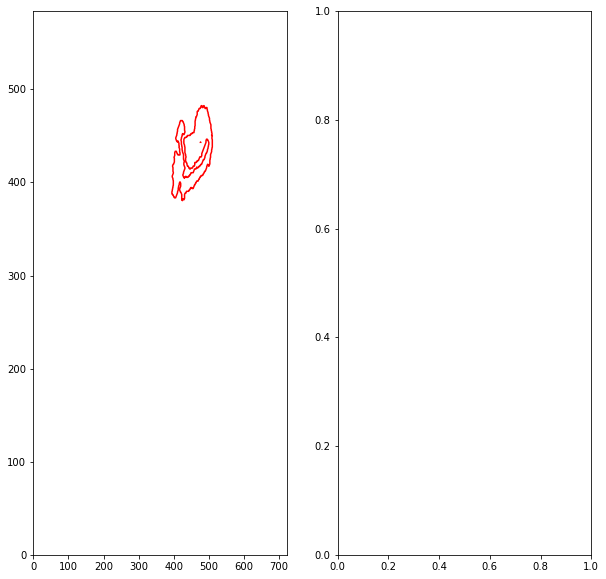

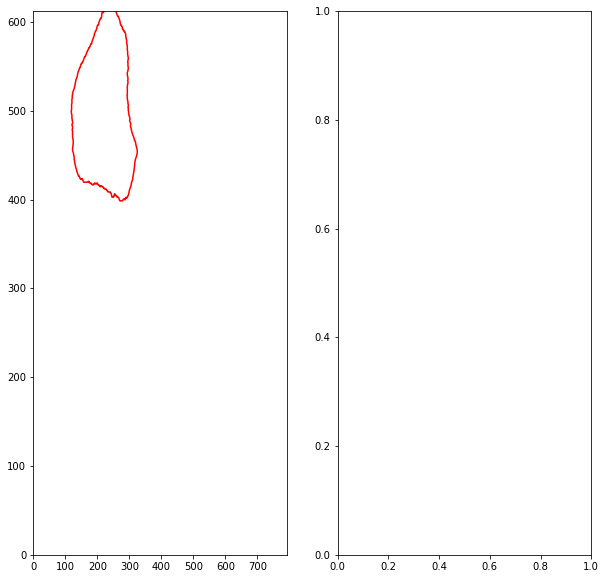

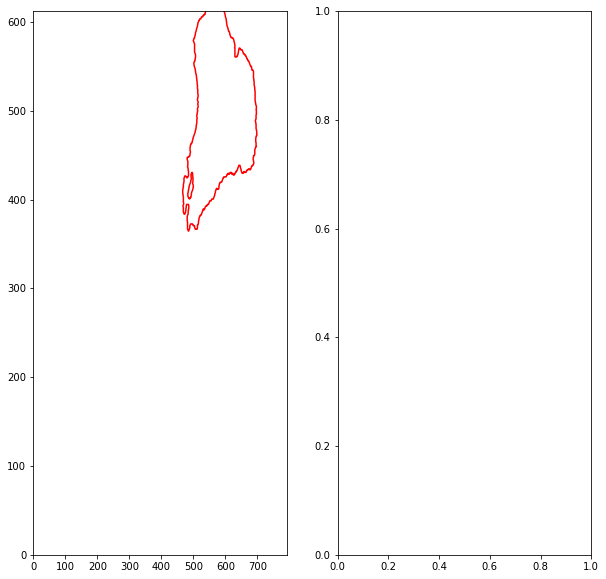

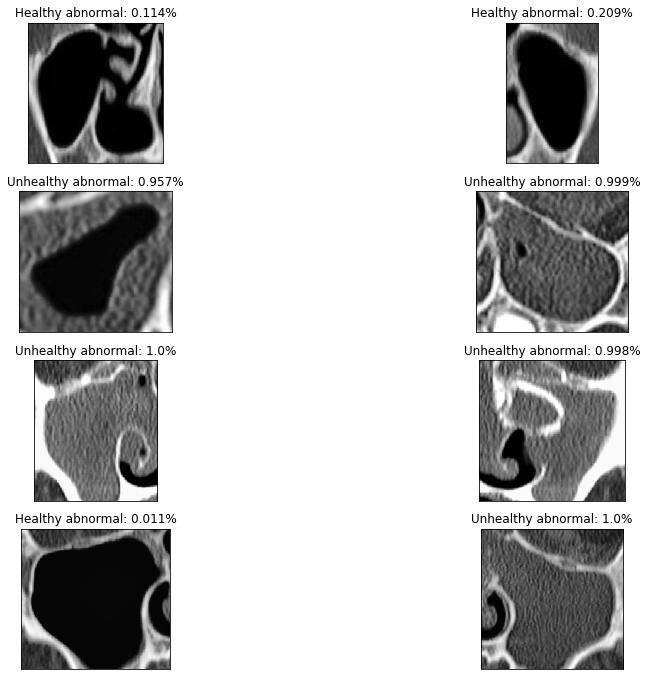

In [16]:
healthy1 = [0] * 4
unhealthy1 = [0] * 4
healthy2 = [0] * 4
unhealthy2 = [0] * 4
result1 = [0] * 4
result2  = [0] * 4
for i in range(len(images)):
    healthy1[i], unhealthy1[i] = diagnosis_sinus(sinus1[i])
    healthy2[i], unhealthy2[i] = diagnosis_sinus(sinus2[i])    
    if (healthy1[i] > unhealthy1[i]):
        result1[i] = "Healthy "
    else: result1[i] = "Unhealthy "
    result1[i] = result1[i] + "abnormal: "+str(round(unhealthy1[i], 3))+"%"
    
    if (healthy2[i] > unhealthy2[i]):
        result2[i] = "Healthy "
    else: result2[i] = "Unhealthy "
    result2[i] = result2[i] + "abnormal: "+str(round(unhealthy2[i], 3))+"%"
    
        
fig = plt.figure(figsize=(15,15))
c=1

for i in range(len(images)):
    plt.subplot(5,2,c),plt.imshow(sinus1[i],cmap = 'gray')                                
    plt.title(result1[i]), plt.xticks([]), plt.yticks([])
    c+=1
    plt.subplot(5,2,c),plt.imshow(sinus2[i],cmap = 'gray')
    plt.title(result2[i]), plt.xticks([]), plt.yticks([])
    c+=1
plt.show()